In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import seaborn as sns
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
!pip install nolds
import nolds
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error
from scipy.linalg import eig
from sklearn.neighbors import NearestNeighbors
from scipy.integrate import odeint

## **Table 1. Lorenz attractor: Chaos in Action**

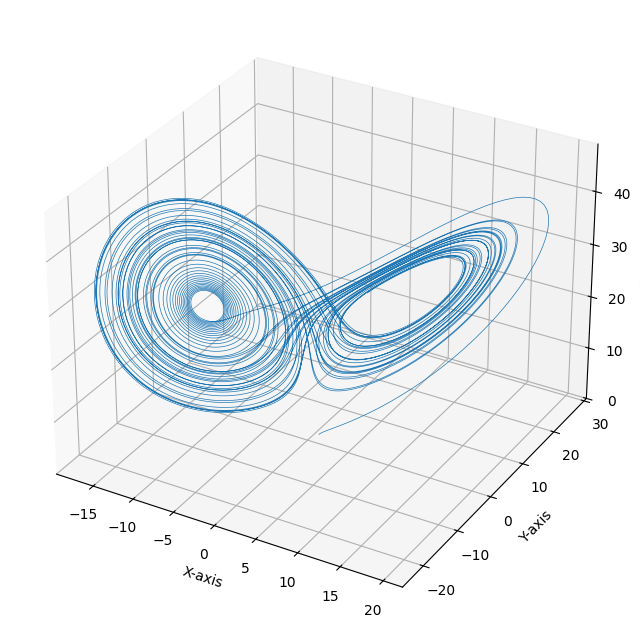

In [ ]:
def lorenz(state, t, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

sigma, rho, beta = 10, 28, 8/3
initial_state = [1.0, 1.0, 1.0]
t = np.linspace(0, 50, 10000)

solution = odeint(lorenz, initial_state, t, args=(sigma, rho, beta))
x, y, z = solution.T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

## **Table 2. Kaldor's Nonlinear Business Cycle (Numerical Solution)**

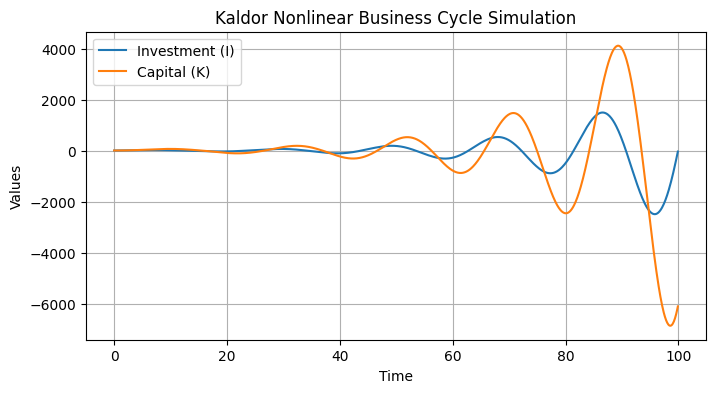

In [ ]:
alpha, beta, gamma, delta = 0.6, 1.5, 2.0, 0.2
T, dt = 100, 0.1
n = int(T/dt)
I, K = np.zeros(n), np.zeros(n)
I[0], K[0] = 0.5, 1.0

# Euler Method
for t in range(n - 1):
    dI = alpha * (beta * (I[t] - delta * K[t]) - I[t]) + gamma * np.arctan(K[t])
    dK = I[t] - delta * K[t]
    I[t + 1] = I[t] + dt * dI
    K[t + 1] = K[t] + dt * dK

plt.figure(figsize=(8, 4))
plt.plot(np.arange(n) * dt, I, label='Investment (I)')
plt.plot(np.arange(n) * dt, K, label='Capital (K)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Kaldor Nonlinear Business Cycle Simulation')
plt.legend()
plt.grid(True)
plt.show()

## **Table 4. Data ingestion: Economic indicators from FRED**

In [ ]:
start = '1990-01-01'; end = '2024-12-31'
cpi = pdr.get_data_fred('CPIAUCSL', start, end)
fedfunds = pdr.get_data_fred('FEDFUNDS', start, end)
unrate = pdr.get_data_fred('UNRATE', start,end)
moneysupply = pdr.get_data_fred('M2SL', start, end)
gdp = pdr.get_data_fred('GDPC1', start, end)

cpi = cpi.reset_index()
fedfunds = fedfunds.reset_index()
unrate = unrate.reset_index()
moneysupply = moneysupply.reset_index()
gdp = gdp.reset_index()

DF = pd.merge(cpi, fedfunds, on='DATE', how='outer')
DF = pd.merge(DF, unrate, on='DATE', how='outer')
DF = pd.merge(DF, moneysupply, on='DATE', how='outer')
DF = pd.merge(DF, gdp, on='DATE', how='outer')

DF = DF.rename(columns={
    'CPIAUCSL': 'CPI',
    'FEDFUNDS': 'InterestRate',
    'UNRATE': 'UnemploymentRate',
    'M2SL': 'M2',
    'GDPC1': 'RealGDP'})

DF.dropna(inplace=True)
DF.set_index('DATE', inplace=True)
print(DF.head())

              CPI  InterestRate  UnemploymentRate      M2    RealGDP
DATE                                                                
1990-01-01  127.5          8.23               5.4  3166.8  10047.386
1990-04-01  128.9          8.26               5.4  3201.6  10083.855
1990-07-01  130.5          8.15               5.5  3224.5  10090.569
1990-10-01  133.4          8.11               5.9  3259.3   9998.704
1991-01-01  134.7          6.91               6.4  3287.7   9951.916


In [ ]:
DF.shape

(140, 5)

In [ ]:
DF.isnull().sum()

,0
CPI,0
InterestRate,0
UnemploymentRate,0
M2,0
RealGDP,0


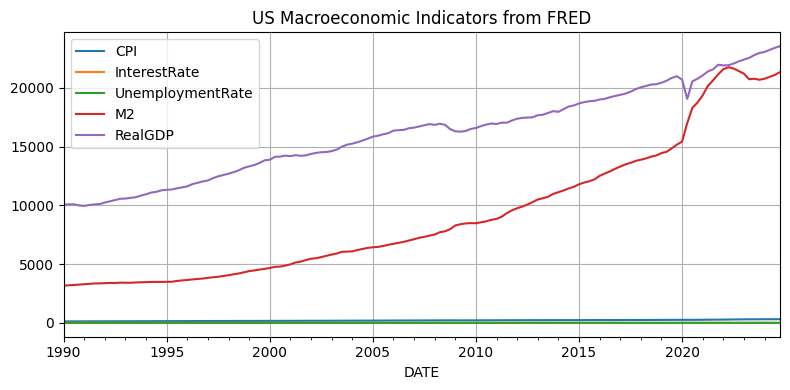

In [ ]:
DF.plot(figsize=(8, 4), title='US Macroeconomic Indicators from FRED')
plt.tight_layout()
plt.grid()
plt.show()

## **Table 7. Implementation of data transformation**

In [ ]:
df = DF.copy()
df['GDP_Growth'] = np.log(df['RealGDP']).diff()
df['Inflation'] = np.log(df['CPI']).diff()
df['Money_Growth'] = np.log(df['M2']).diff()
df['Lag_GDP_Growth'] = df['GDP_Growth'].shift(1)
df.dropna(inplace=True)
df.head()

,CPI,InterestRate,UnemploymentRate,M2,RealGDP,GDP_Growth,Inflation,Money_Growth,Lag_GDP_Growth
DATE,,,,,,,,,
1990-07-01,130.5,8.15,5.5,3224.5,10090.569,0.000666,0.012336,0.007127,0.003623
1990-10-01,133.4,8.11,5.9,3259.3,9998.704,-0.009146,0.021979,0.010735,0.000666
1991-01-01,134.7,6.91,6.4,3287.7,9951.916,-0.004690,0.009698,0.008676,-0.009146
1991-04-01,135.1,5.91,6.7,3332.4,10029.510,0.007767,0.002965,0.013505,-0.004690
1991-07-01,136.2,5.82,6.8,3356.1,10080.195,0.005041,0.008109,0.007087,0.007767


## **Table 8. Data stationarity test**

In [ ]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    p = result[1]
    print(f"{name}: p = {p:.4f} → {'Stationary' if p < 0.05 else 'Non-stationary'}")

adf_test(df['Lag_GDP_Growth'], 'Lag_GDP_Growth')
adf_test(df['InterestRate'], 'InterestRate')
adf_test(df['Inflation'], 'Inflation')
adf_test(df['UnemploymentRate'], 'UnemploymentRate')
adf_test(df['Money_Growth'], 'Money_Growth')

Lag_GDP_Growth: p = 0.0000 → Stationary
InterestRate: p = 0.0360 → Stationary
Inflation: p = 0.0000 → Stationary
UnemploymentRate: p = 0.0047 → Stationary
Money_Growth: p = 0.0019 → Stationary


## **Table 9. Variation Inflation Factor test**

In [ ]:
X = df[[
    'Lag_GDP_Growth', 'InterestRate', 'Inflation', 'UnemploymentRate', 'Money_Growth']]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            feature       VIF
0    Lag_GDP_Growth  1.397860
1      InterestRate  2.044377
2         Inflation  2.123226
3  UnemploymentRate  4.494220
4      Money_Growth  2.861583


## **Table 10. A macro-financial system of two coupled SDEs (GDP-Growth and Interest-Rate). sigmaY * dW_Y and sigmai * dW_i terms inject random noise, turning the deterministic IS-LM model into a stochastic IS-LM system, better reflecting real macroeconomic volatility. Solved using Euler-Maruyama approximation. This is a simplified IS-LM economic structure with stochastic shocks**

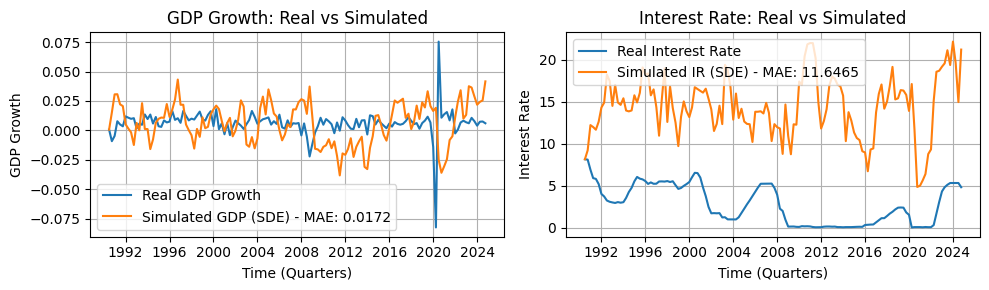

In [22]:
X = df[['Lag_GDP_Growth', 'UnemploymentRate', 'InterestRate', 'Inflation', 'Money_Growth']]
X = sm.add_constant(X)
y = df['GDP_Growth']
model_gdp = sm.OLS(y, X).fit()
sigmaY = np.std(model_gdp.resid)

Xi = df[['GDP_Growth', 'Money_Growth', 'Inflation']]
Xi = sm.add_constant(Xi)
yi = df['InterestRate']
model_ir = sm.OLS(yi, Xi).fit()
sigmai = np.std(model_ir.resid)

# coefficients GDP model
gamma_coeffs = model_gdp.params
const = gamma_coeffs['const']
beta_lag = gamma_coeffs['Lag_GDP_Growth']
beta_unemp = gamma_coeffs['UnemploymentRate']
beta_ir = gamma_coeffs['InterestRate']
beta_inf = gamma_coeffs['Inflation']
beta_money = gamma_coeffs['Money_Growth']

# coefficients interest rate model
ir_coeffs = model_ir.params
ir_const = ir_coeffs['const']
ir_gdp = ir_coeffs['GDP_Growth']
ir_money = ir_coeffs['Money_Growth']
ir_inf = ir_coeffs['Inflation']

# Simulation
Y_data = df['GDP_Growth'].values
i_data = df['InterestRate'].values
M_data = (df['Money_Growth'] - df['Inflation']).values
U_data = df['UnemploymentRate'].values
Lag_Y = df['Lag_GDP_Growth'].values
Infl = df['Inflation'].values
T = len(df)
dt = 1.0

Y_ols = np.zeros(T)
i_ols = np.zeros(T)
Y_ols[0], i_ols[0] = Y_data[0], i_data[0]

resid_gdp = model_gdp.resid
resid_ir = model_ir.resid
corr = np.corrcoef(resid_gdp, resid_ir)[0, 1]
cov = np.array([[1, corr], [corr, 1]])

for t in range(1, T):
    # Correlated shocks
    dW_Y, dW_i = np.random.multivariate_normal([0, 0], cov).T * np.sqrt(dt)

    # GDP with mean-reversion (α=0.1)
    dY = (const + beta_lag * Y_ols[t-1] + beta_unemp * U_data[t-1] +
          beta_ir * i_ols[t-1] + beta_inf * Infl[t-1] + beta_money * M_data[t-1] -
          0.1 * Y_ols[t-1]) * dt + sigmaY * dW_Y

    # Interest rates with mean-reversion (α=0.2)
    di = (ir_const + ir_gdp * Y_ols[t-1] + ir_money * M_data[t-1] +
          ir_inf * Infl[t-1] - 0.2 * i_ols[t-1]) * dt + sigmai * dW_i

    Y_ols[t] = Y_ols[t-1] + dY
    i_ols[t] = i_ols[t-1] + di

mae_gdp = mean_absolute_error(Y_data, Y_ols)
mae_ir = mean_absolute_error(i_data, i_ols)

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(df.index, Y_data, label='Real GDP Growth')
plt.plot(df.index, Y_ols, label=f'Simulated GDP (SDE) - MAE: {mae_gdp:.4f}')
plt.xlabel('Time (Quarters)')
plt.ylabel('GDP Growth')
plt.title("GDP Growth: Real vs Simulated")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.index, i_data, label='Real Interest Rate')
plt.plot(df.index, i_ols, label=f'Simulated IR (SDE) - MAE: {mae_ir:.4f}')
plt.xlabel('Time (Quarters)')
plt.ylabel('Interest Rate')
plt.title("Interest Rate: Real vs Simulated")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Table 11. Second-order Runge-Kutta method (RK2) for simulating the coupled stochastic differential equations (SDEs) of GDP-Growth and Interest-Rate dynamics**

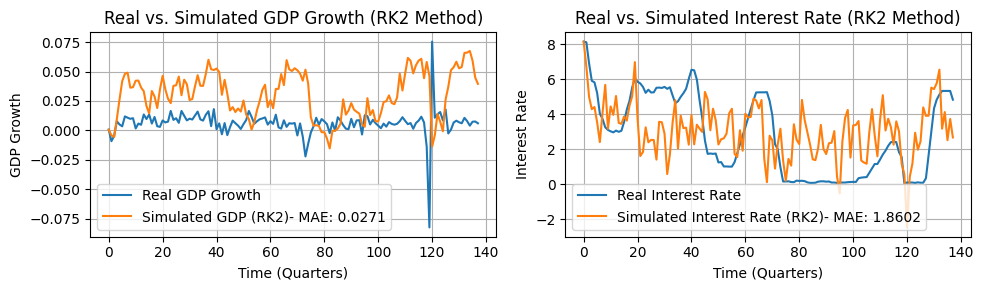

In [24]:
T = len(df)
dt = 1.0

Y_rk2 = np.zeros(T)
i_rk2 = np.zeros(T)
Y_rk2[0], i_rk2[0] = Y_data[0], i_data[0]

def gdp_drift(Y_prev, i_prev, U_prev, M_prev, Infl_prev):
    return (const + beta_lag * Y_prev + beta_unemp * U_prev +
            beta_ir * i_prev + beta_inf * Infl_prev + beta_money * M_prev)

def ir_drift(Y_prev, i_prev, M_prev, Infl_prev):
    return (ir_const + ir_gdp * Y_prev + ir_money * M_prev +
            ir_inf * Infl_prev - i_prev)

# RK2 Simulation
np.random.seed(42)
for t in range(1, T):
    dW_Y = np.random.normal(0, np.sqrt(dt))
    dW_i = np.random.normal(0, np.sqrt(dt))
    dW_Y, dW_i = np.random.multivariate_normal([0, 0], cov).T * np.sqrt(dt)


    # GDP Growth (RK2)
    k1_Y = gdp_drift(Y_rk2[t-1], i_rk2[t-1], U_data[t-1], M_data[t-1], Infl[t-1])
    Y_mid = Y_rk2[t-1] + 0.5 * k1_Y * dt + 0.5 * sigmaY * dW_Y

    k2_Y = gdp_drift(Y_mid, i_rk2[t-1], U_data[t-1], M_data[t-1], Infl[t-1])
    Y_rk2[t] = Y_rk2[t-1] + k2_Y * dt + sigmaY * dW_Y

    # Interest Rate (RK2)
    k1_i = ir_drift(Y_rk2[t-1], i_rk2[t-1], M_data[t-1], Infl[t-1])
    i_mid = i_rk2[t-1] + 0.5 * k1_i * dt + 0.5 * sigmai * dW_i

    k2_i = ir_drift(Y_mid, i_mid, M_data[t-1], Infl[t-1])
    i_rk2[t] = i_rk2[t-1] + k2_i * dt + sigmai * dW_i

mae_gdp = np.mean(np.abs(Y_data - Y_rk2))
mae_ir = np.mean(np.abs(i_data - i_rk2))

time = np.arange(T)

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(time, Y_data, label='Real GDP Growth')
plt.plot(time, Y_rk2, label=f'Simulated GDP (RK2)- MAE: {mae_gdp:.4f}')
plt.xlabel('Time (Quarters)')
plt.ylabel('GDP Growth')
plt.title('Real vs. Simulated GDP Growth (RK2 Method)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(time, i_data, label='Real Interest Rate')
plt.plot(time, i_rk2, label=f'Simulated Interest Rate (RK2)- MAE: {mae_ir:.4f}')
plt.xlabel('Time (Quarters)')
plt.ylabel('Interest Rate')
plt.title('Real vs. Simulated Interest Rate (RK2 Method)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Table 12. Stability analysis using Jacobian**

In [25]:
Y_star = np.mean(Y_data)
r_star = np.mean(i_data)

J = np.array([
    [beta_lag,       beta_ir],      # ∂f/∂Y, ∂f/∂r
    [ir_gdp,        -1.0]])         # ∂g/∂Y, ∂g/∂r (mean-reversion coefficient)

eigenvalues = np.linalg.eigvals(J)
print(f"Jacobian Matrix:\n{J}")

eigenvalues, _ = eig(J)
print("Eigenvalues:", eigenvalues)

if np.all(np.real(eigenvalues) < 0):
    print("Stable equilibrium (perturbations decay).")
elif np.all(np.real(eigenvalues) > 0):
    print("Unstable equilibrium (perturbations grow).")
elif np.any(np.real(eigenvalues) > 0) and np.any(np.real(eigenvalues) < 0):
    print("Saddle point (stable in some directions, unstable in others).")
elif np.all(np.real(eigenvalues) == 0):
    if np.all(np.imag(eigenvalues) != 0):
        print("Center (stable oscillations in linear approximation).")
    else:
        print("Non-hyperbolic (requires nonlinear analysis).")

stable = all(np.real(eigenvalues) < 0)
print("System is stable at equilibrium:", stable)

Jacobian Matrix:
[[-2.86104652e-01 -5.42317406e-04]
 [-3.99383450e+00 -1.00000000e+00]]
Eigenvalues: [-0.28308348+0.j -1.00302117+0.j]
Stable equilibrium (perturbations decay).
System is stable at equilibrium: True


## **Table 13. Phase diagram: Stability analysis**

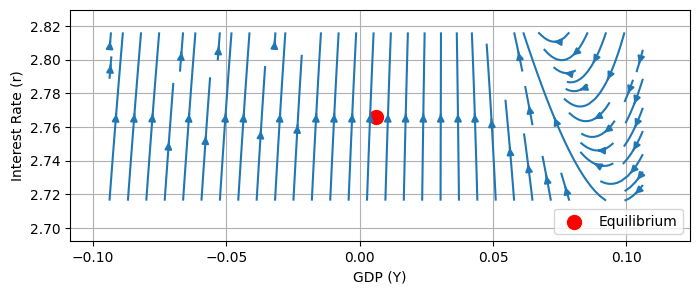

In [26]:
Y_range = np.linspace(Y_star - 0.1, Y_star + 0.1, 20)
r_range = np.linspace(r_star - 0.05, r_star + 0.05, 20)
Y_grid, r_grid = np.meshgrid(Y_range, r_range)

dY = gdp_drift(Y_grid, r_grid, np.mean(U_data), np.mean(M_data), np.mean(Infl))
dr = ir_drift(Y_grid, r_grid, np.mean(M_data), np.mean(Infl))

plt.figure(figsize=(8, 3))
plt.streamplot(Y_grid, r_grid, dY, dr)
plt.scatter(Y_star, r_star, c='r', s=100, label='Equilibrium')
plt.xlabel('GDP (Y)')
plt.ylabel('Interest Rate (r)')
plt.title('Phase Diagram: Stability Analysis')
plt.legend()
plt.grid()
plt.show()

## **Table 14. Lyapunov exponent estimation using algorithm by Benettin et al. [5]) per variable (GDP and Interest Rate) based Runge-Kutta stochastic simulation model**

In [ ]:
epsilon = 1e-5
steps = 1000
dt = 1.0

Y = np.zeros(steps)
i = np.zeros(steps)
Y_perturbed = np.zeros(steps)
i_perturbed = np.zeros(steps)

# Initial conditions using last available data point
Y[0] = Y_data[-1]
i[0] = i_data[-1]
Y_perturbed[0] = Y[0] + epsilon
i_perturbed[0] = i[0] + epsilon

# Initialize sum of log-divergences for each variable
sum_ln_div_Y = 0.0
sum_ln_div_i = 0.0
sum_ln_div_joint = 0.0

np.random.seed(42)

data_len = len(Y_data)

for t in range(1, steps):
    dW_Y = np.random.normal(0, np.sqrt(dt))
    dW_i = np.random.normal(0, np.sqrt(dt))

    u_prev = U_data[(t-1) % data_len]
    m_prev = M_data[(t-1) % data_len]
    infl_prev = Infl[(t-1) % data_len]

    k1_Y = gdp_drift(Y[t-1], i[t-1], u_prev, m_prev, infl_prev)
    Y_mid = Y[t-1] + 0.5 * k1_Y * dt + 0.5 * sigmaY * dW_Y
    k2_Y = gdp_drift(Y_mid, i[t-1], u_prev, m_prev, infl_prev)
    Y[t] = Y[t-1] + k2_Y * dt + sigmaY * dW_Y

    k1_i = ir_drift(Y[t-1], i[t-1], m_prev, infl_prev)
    i_mid = i[t-1] + 0.5 * k1_i * dt + 0.5 * sigmai * dW_i
    k2_i = ir_drift(Y_mid, i_mid, m_prev, infl_prev)
    i[t] = i[t-1] + k2_i * dt + sigmai * dW_i

    k1_Yp = gdp_drift(Y_perturbed[t-1], i_perturbed[t-1], u_prev, m_prev, infl_prev)
    Yp_mid = Y_perturbed[t-1] + 0.5 * k1_Yp * dt + 0.5 * sigmaY * dW_Y
    k2_Yp = gdp_drift(Yp_mid, i_perturbed[t-1], u_prev, m_prev, infl_prev)
    Y_pert_next = Y_perturbed[t-1] + k2_Yp * dt + sigmaY * dW_Y

    k1_ip = ir_drift(Y_perturbed[t-1], i_perturbed[t-1], m_prev, infl_prev)
    ip_mid = i_perturbed[t-1] + 0.5 * k1_ip * dt + 0.5 * sigmai * dW_i
    k2_ip = ir_drift(Yp_mid, ip_mid, m_prev, infl_prev)
    i_pert_next = i_perturbed[t-1] + k2_ip * dt + sigmai * dW_i

    dY = Y_pert_next - Y[t]
    di = i_pert_next - i[t]
    dist = np.sqrt(dY**2 + di**2)

    if np.abs(dY) > 1e-10:
        sum_ln_div_Y += np.log(np.abs(dY) / epsilon)
    if np.abs(di) > 1e-10:
        sum_ln_div_i += np.log(np.abs(di) / epsilon)
    if dist > 1e-10:
         sum_ln_div_joint += np.log(dist / epsilon)

    if dist > 1e-10:
        Y_perturbed[t] = Y[t] + epsilon * dY / dist
        i_perturbed[t] = i[t] + epsilon * di / dist
    else:
        Y_perturbed[t] = Y[t]
        i_perturbed[t] = i[t]

lyap_Y = sum_ln_div_Y / (steps -1 ) if steps > 1 else 0.0
lyap_i = sum_ln_div_i / (steps -1 ) if steps > 1 else 0.0
lyap_joint = sum_ln_div_joint / (steps -1 ) if steps > 1 else 0.0

print(f"Lyapunov Exponent (Joint): {lyap_joint:.5f}")
print(f"Lyapunov Exponent (GDP only):{lyap_Y:.5f}")
print(f"Lyapunov Exponent (Joint):{lyap_joint:.5f}")
print(f"Lyapunov Exponent (GDP only):{lyap_Y:.5f}")
print(f"Lyapunov Exponent (Interest Rate):{lyap_i:.5f}")

Lyapunov Exponent (Joint): -0.27613
Lyapunov Exponent (GDP only):-2.00491
Lyapunov Exponent (Joint):-0.27613
Lyapunov Exponent (GDP only):-2.00491
Lyapunov Exponent (Interest Rate):-0.29237


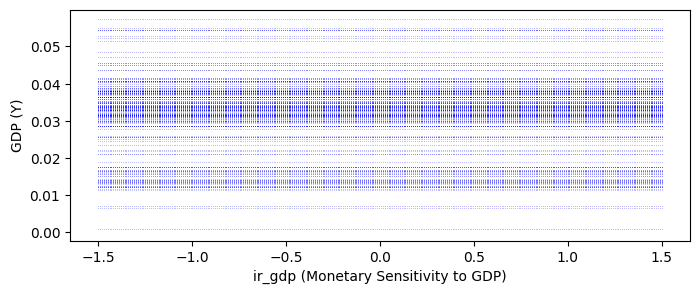

In [ ]:
ir_gdp_values = np.linspace(-1.5, 1.5, 300)
T_bif = 500
transient = 300
Y_bif = []

for param in ir_gdp_values:
    Y = np.zeros(T_bif)
    i = np.zeros(T_bif)
    Y[0], i[0] = 0.0, 0.0
    for t in range(1, T_bif):
        k1_Y = gdp_drift(Y[t-1], i[t-1], U_data[t%len(U_data)], M_data[t%len(M_data)], Infl[t%len(Infl)])
        k2_Y = gdp_drift(Y[t-1] + 0.5 * k1_Y * dt, i[t-1], U_data[t%len(U_data)], M_data[t%len(M_data)], Infl[t%len(Infl)])
        Y[t] = Y[t-1] + k2_Y * dt

        k1_i = ir_drift(Y[t-1], i[t-1], M_data[t%len(M_data)], Infl[t%len(Infl)])
        k2_i = ir_drift(Y[t-1], i[t-1] + 0.5 * k1_i * dt, M_data[t%len(M_data)], Infl[t%len(Infl)])
        i[t] = i[t-1] + k2_i * dt

    Y_bif.extend([(param, y) for y in Y[transient:]])

Y_bif = np.array(Y_bif)

plt.figure(figsize=(8, 3))
plt.plot(Y_bif[:, 0], Y_bif[:, 1], ',b', alpha=0.25)
plt.xlabel("ir_gdp (Monetary Sensitivity to GDP)")
plt.ylabel("GDP (Y)")
# plt.title("Bifurcation Diagram of GDP vs ir_gdp")
plt.show()

## **Table 15. Lyapunov exponent using algorithm by Rosenstein et al. and plot divergence curves**

GDP Growth Lyapunov exponent: -0.0052
Inflation Lyapunov exponent: 0.0077
Money Growth Lyapunov exponent: 0.0021


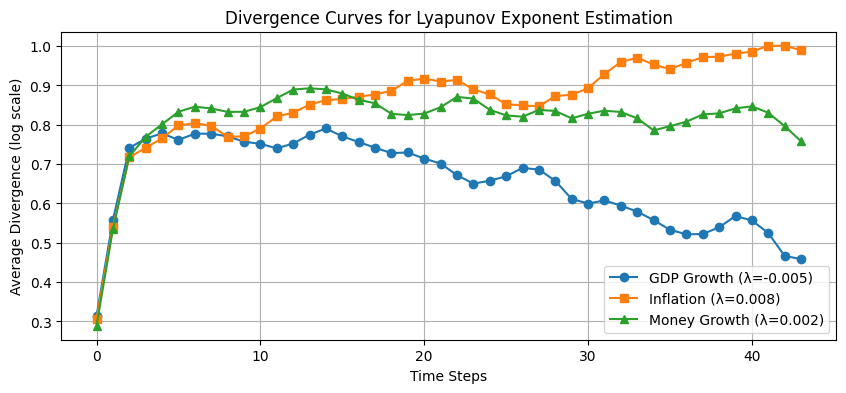

In [ ]:
data = DF.copy()
data['GDP_Growth'] = np.log(data['RealGDP']).diff()
data['Inflation'] = np.log(data['CPI']).diff()
data['Money_Growth'] = np.log(data['M2']).diff()
data['Lag_GDP_Growth'] = data['GDP_Growth'].shift(1)
data.dropna(inplace=True)

gdp_series = data['GDP_Growth'].values
inflation_series = data['Inflation'].values
money_series = data['Money_Growth'].values

# Normalize
gdp_norm = (gdp_series - np.mean(gdp_series)) / np.std(gdp_series)
inflation_norm = (inflation_series - np.mean(inflation_series)) / np.std(inflation_series)
money_norm = (money_series - np.mean(money_series)) / np.std(money_series)

def lyapunov_exponent(series, emb_dim=3, tau=1, n_neighbors=20, min_tsep=10, evolution_time=1):
    n = len(series)
    m = n - (emb_dim - 1) * tau
    if m <= 0:
        raise ValueError("Embedding dimension or time delay too large")

    # Phase space reconstruction
    indices = np.arange(m)
    for i in range(1, emb_dim):
        indices = np.vstack((indices, np.arange(i*tau, i*tau + m)))

    embedded = series[indices].T

    # nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='auto').fit(embedded)
    distances, indices = nbrs.kneighbors(embedded)

    # Filter neighbors that are too close in time
    valid = np.zeros_like(distances, dtype=bool)
    for i in range(len(embedded)):
        for j in range(1, n_neighbors+1):
            if abs(i - indices[i, j]) > min_tsep:
                valid[i, j] = True

    # divergence over time
    max_time = min(50, len(embedded)//3)
    t = np.arange(evolution_time, max_time)
    s = np.zeros(len(t))
    count = np.zeros(len(t))

    for i in range(len(embedded)):
        for j in range(1, n_neighbors+1):
            if valid[i, j]:
                idx1 = i
                idx2 = indices[i, j]
                dist0 = np.linalg.norm(embedded[idx1] - embedded[idx2])

                for k, time in enumerate(t):
                    idx1_evol = min(idx1 + time, len(embedded)-1)
                    idx2_evol = min(idx2 + time, len(embedded)-1)
                    dist1 = np.linalg.norm(embedded[idx1_evol] - embedded[idx2_evol])

                    if dist1 > 0 and dist0 > 0:
                        s[k] += np.log(dist1 / dist0)
                        count[k] += 1

    valid_points = count > (0.2 * n_neighbors * len(embedded))
    t_valid = t[valid_points]
    s_valid = s[valid_points] / count[valid_points]

    if len(t_valid) < 2:
        return np.nan, np.nan

    lyap_exp, _ = np.polyfit(t_valid, s_valid, 1)
    return lyap_exp, s_valid

# Lyapunov exponents
gdp_lyap, gdp_curve = lyapunov_exponent(gdp_norm)
inflation_lyap, inflation_curve = lyapunov_exponent(inflation_norm)
money_lyap, money_curve = lyapunov_exponent(money_norm)

print(f"GDP Growth Lyapunov exponent: {gdp_lyap:.4f}")
print(f"Inflation Lyapunov exponent: {inflation_lyap:.4f}")
print(f"Money Growth Lyapunov exponent: {money_lyap:.4f}")

plt.figure(figsize=(10, 4))

if not np.isnan(gdp_lyap):
    plt.plot(gdp_curve, label=f'GDP Growth (λ={gdp_lyap:.3f})', marker='o')
if not np.isnan(inflation_lyap):
    plt.plot(inflation_curve, label=f'Inflation (λ={inflation_lyap:.3f})', marker='s')
if not np.isnan(money_lyap):
    plt.plot(money_curve, label=f'Money Growth (λ={money_lyap:.3f})', marker='^')

plt.xlabel('Time Steps')
plt.ylabel('Average Divergence (log scale)')
plt.title('Divergence Curves for Lyapunov Exponent Estimation')
plt.legend()
plt.grid(True)
plt.show()

## **Table 16. Bootstrap confidence intervals for Lyapunov exponent of Inflation variable**

Inflation λ 95% CI: [-0.0057, 0.0122]


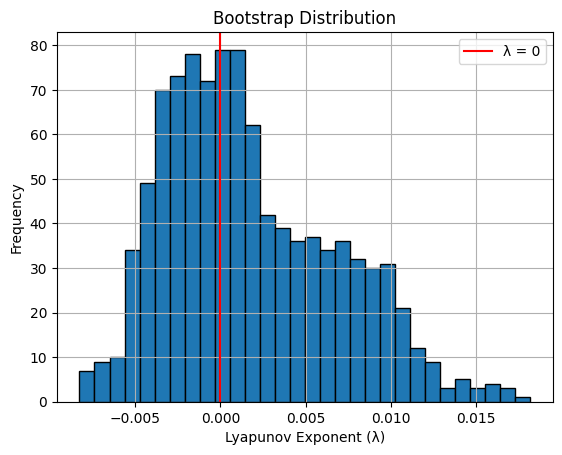

In [ ]:
n_bootstraps = 1000
inflation_lyap_boot = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    sample = np.random.choice(inflation_norm, size=len(inflation_norm), replace=True)
    inflation_lyap_boot[i], _ = lyapunov_exponent(sample)
print(f"Inflation λ 95% CI: [{np.percentile(inflation_lyap_boot, 2.5):.4f}, {np.percentile(inflation_lyap_boot, 97.5):.4f}]")

plt.hist(inflation_lyap_boot, bins=30, edgecolor='k')
plt.axvline(x=0, color='r', label='λ = 0')
plt.xlabel('Lyapunov Exponent (λ)')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution')
plt.legend()
plt.grid()
plt.show()

## **Table 17. Parameters for Monte Carlo simulations**

In [ ]:
# quarterly volatility
vol = np.std(data['Inflation'][:-2])

# annualized volatility
vol_A = vol * np.sqrt(4)

# spot CPI as of the first date in the data
I0 = data['CPI'].iloc[0]

# nominal and real risk-free rates
r = 0.0451
rf = 0.0121

# instantaneous expected inflation rate (Fisher equation approximation)
mu = r - rf

# volatility
sigma = vol_A

# simulation parameters
T = 1
N = 4
dt = T / N

M = int(5 * 1e4)

print(f"The quarterly volatility of the inflation rates is: {vol:.3%}")
print(f"The annualized volatility of the inflation rates is: {vol_A:.3%}")
print(f"The spot CPI as of the valuation date is: {I0:.1f}")
print(f"The nominal risk free rate is: {r:.3%}")
print(f"The real risk free rate is: {rf:.3%}")
print(f"The instantaneous expected inflation rate is: {mu:.4f}")
print(f"The volatility of the inflation rates (annualized) is: {sigma:.4f}")
print(f"The time increment dt is: {dt}")
print(f"The number of simulations M is: {M}")

The quarterly volatility of the inflation rates is: 0.607%
The annualized volatility of the inflation rates is: 1.213%
The spot CPI as of the valuation date is: 130.5
The nominal risk free rate is: 4.510%
The real risk free rate is: 1.210%
The instantaneous expected inflation rate is: 0.0330
The volatility of the inflation rates (annualized) is: 0.0121
The time increment dt is: 0.25
The number of simulations M is: 50000


## **Table 18. Monte Carlo simulation for the inflation rate, using Geometric Brownian Motion model**

Inflation rate forecast for 2025 is 3.37% with a standard error of sample mean of 0.006%


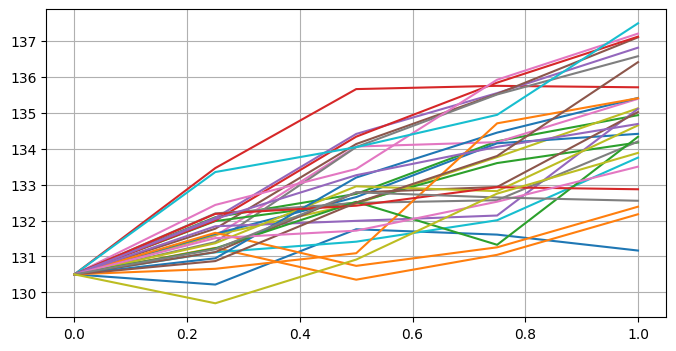

In [ ]:
dW = np.random.randn(M,N)
I = I0 * np.ones((M, N+1))

for i in range(0,N):
    I[:,i+1] = I[:,i] * np.exp((mu - 0.5 * sigma**2) * dt + dW[:, i] * sigma * np.sqrt(dt))

plt.figure(figsize=(8, 4))
a = [ np.random.randint(0, M) for j in range(1, 30)]
for simu in a:
    plt.plot(np.arange(0, T+dt, dt), I[simu])
    plt.grid()

res = (I[:,-1]/I0-1)
print("Inflation rate forecast for 2025 is {:.2%} with a standard error of sample mean of {:.3%}".format(np.mean(res),np.std(res)/np.sqrt(M)))

## **Table 19. Forecast and standard error**

In [ ]:
res = (I[:,-1]/I0-1)
inflation_forecast = np.mean(res)
standard_error = np.std(res) / np.sqrt(M)

print(f"Inflation rate forecast for 2025 is {inflation_forecast:.2%}")
print(f"Standard error of sample mean: {standard_error:.3%}")

Inflation rate forecast for 2025 is 3.37%
Standard error of sample mean: 0.006%


## **Table 20. Hamiltonian-informed optimization: The optimization yields a declining consumption path, consistent with the chosen discount factor (β=0.95) and interest rate**

Optimal Consumption Path (first 4 periods): [24712.75985691 24079.69311648 23478.54523362 22883.8414106 ]
Total Discounted Utility (Maximized): 192.44


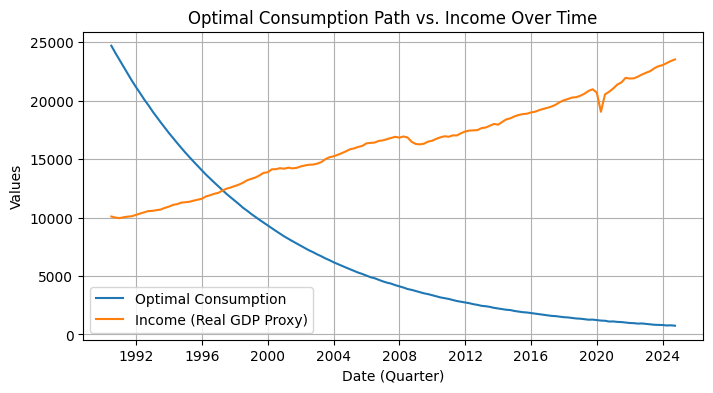

Initial Wealth (W0): 10090.57
Present Value of Income Stream: 468623.24
Total Present Value of Resources (W0 + PV_Income): 478713.80
Total Present Value of Optimal Consumption: 478713.80
Budget Constraint Met (difference): 0.000000


In [ ]:
def hamiltonian_consumption(W0, income_stream, r, beta, T):
    discount_factors = (1 + r) ** np.arange(T)
    pv_income = np.sum(income_stream / discount_factors)
    total_resources = W0 + pv_income

    growth_factors = (beta * (1 + r)) ** np.arange(T)
    C = (growth_factors / np.sum(growth_factors)) * total_resources
    return C

W0 = df['RealGDP'].iloc[0]
r = df['InterestRate'].mean() / 100
T = len(df)
income_stream = df['RealGDP'].values
beta = 0.95

C_hamiltonian = hamiltonian_consumption(W0, income_stream, r, beta, T)
initial_guess = hamiltonian_consumption(W0, income_stream, r, beta, T)

def total_utility(consumption):
    if np.any(consumption <= 0):
        return np.inf
    return -sum((beta**t) * np.log(c) for t, c in enumerate(consumption[:T]))

"""Budget Constraint (Present Value of Consumption = Present Value of Wealth + Income)
Sum[c_t / (1+r)^t] = W0 + Sum[income_t / (1+r)^t]
Rearranged: Sum[c_t / (1+r)^t] - Sum[income_t / (1+r)^t] - W0 = 0"""

def budget_constraint(consumption):
    discount_factors = (1 + r) ** np.arange(T)
    return sum(consumption[:T] / discount_factors) - W0 - sum(income_stream[:T] / discount_factors)

"""Initial guess for the consumption path
A simple guess: distribute PV of total resources (W0 + PV_income) equally in PV terms across periods
Total PV resources = W0 + pv_income (calculated outside the function for the guess)
Use the correct income_stream length for calculating temp_pv_income"""

pv_income = sum(income_stream / ((1 + r) ** np.arange(T)))
initial_guess = np.full(T, (W0 + pv_income) / T)

result = minimize(
    total_utility,
    initial_guess,
    method='SLSQP',
    bounds=[(1e-8, None)] * T,
    constraints={'type': 'eq', 'fun': budget_constraint, 'args': (income_stream, r, W0, T)})

if result.success:
    optimal_consumption_path = result.x
    print(f"Optimal Consumption Path (first 4 periods): {optimal_consumption_path[:4]}")
    print(f"Total Discounted Utility (Maximized): {-result.fun:.2f}")

    plt.figure(figsize=(8, 4))
    plt.plot(df.index, optimal_consumption_path, label='Optimal Consumption')
    plt.plot(df.index, income_stream, label='Income (Real GDP Proxy)')
    plt.xlabel('Date (Quarter)')
    plt.ylabel('Values')
    plt.title('Optimal Consumption Path vs. Income Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    calculated_discounted_consumption = sum(optimal_consumption_path[t] / ((1 + r)**t) for t in range(T))
    calculated_pv_income = sum(income_stream[t] / ((1 + r)**t) for t in range(T))
    print(f"Initial Wealth (W0): {W0:.2f}")
    print(f"Present Value of Income Stream: {calculated_pv_income:.2f}")
    print(f"Total Present Value of Resources (W0 + PV_Income): {W0 + calculated_pv_income:.2f}")
    print(f"Total Present Value of Optimal Consumption: {calculated_discounted_consumption:.2f}")
    print(f"Budget Constraint Met (difference): {budget_constraint(optimal_consumption_path, income_stream, r, W0, T):.6f}")
else:
    print("Optimization failed.")
    print("Consider adjusting initial guess, bounds, constraints, or optimizer options.")